In [42]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Define a quartely time schema
years_in_model = 3
quarters = range(1, years_in_model * 4 + 1)
quarter_labels = ['Q' + str(q) for q in quarters]

quarter_labels
#### STEP 1:  Calculate simple non-discounted cost-benefit cash flows for a single quarter with a delay ramp, and max
#### STEP 2:  Use those cash flows to find a discounted cash flow for each project using Net Present Value (NPV)
#### STEP 3:  Assemble the net present value of estimated future cash flows across projects in the portfolio
#### STEP 4:  Show a composite overall return, and let the user change paramaters, risk levels, timing, etc. to optimize and plan

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']

Exception: max_amt must be > scale_up_qtrs / 2

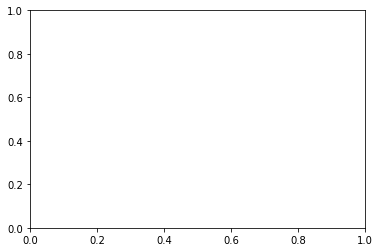

In [349]:
class PortfolioModel():
    
    def __init__(self, delay_qtrs, max_amt, scale_up_qtrs, tot_qtrs=12):
        if scale_up_qtrs < 2: 
            raise 'the total number of quarters must be at least one'
        self.delay_qtrs = delay_qtrs
        self.max_amt = max_amt
        self.scale_up_qtrs = scale_up_qtrs
        self.tot_qtrs = tot_qtrs
        
    def _sigmoid(self, x):
        x_naught =  self.scale_up_qtrs / 2
        k = math.log(1/.95 - 1) / (self.max_amt - x_naught)
        if k < 0:
            raise Exception("max_amt must be > scale_up_qtrs / 2")
        return self.max_amt / (1 + math.exp(-k *(x - x_naught - self.delay_qtrs)))
    
    def _linear(self, x):
        """y = mx + b. Units in amount (returned value) per quarter (x)"""
        m = self.max_amt / self.scale_up_qtrs
        b = -m * self.delay_qtrs
        return min(m * x + b, self.max_amt) # Never return more than max
    
    def _single(self, x):
        if x == self.delay_qtrs:
            return self.max_amt
        else:
            return 0
    
    def _step(self, x):
        return self.max_amt
    
    def _calculate_qtr(self, f):
        values = []
        for quarter_n in range(0, self.tot_qtrs):
            if quarter_n < self.delay_qtrs:
                values.append(0)
            else:
                values.append(f(quarter_n))
        return values

    def quick_view(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(range(self.tot_qtrs), self.sigmoid_qtr, label='sigmoid')
#         ax.plot(range(self.tot_qtrs), self.linear_qtr, label='linear')
#         ax.plot(range(self.tot_qtrs), self.step_qtr, label='step')
#         ax.scatter(range(self.tot_qtrs), self.single_qtr, label='single')
        ax.legend(loc='upper left')
        ax.grid(True)
    
    @property
    def sigmoid_qtr(self):
#         quarterly_x = PortfolioModel.SIGMOID_SHIFT * 2 / self.scale_up_qtrs
        return self._calculate_qtr(self._sigmoid)
    
    @property
    def linear_qtr(self):
        return self._calculate_qtr(self._linear)
    
    @property
    def step_qtr(self):
        return self._calculate_qtr(self._step)
    
    @property
    def single_qtr(self):
        return self._calculate_qtr(self._single)

delay_qtrs = 3
max_amt = 5
scale_up_qtrs = 7
pm = PortfolioModel(delay_qtrs, max_amt, scale_up_qtrs)

# pm.sigmoid_qtr
def pp(name, lst):
    print(f"\n{name}")
    print('\t'.join(["{0:.2f}".format(i) for i in lst]))

# pp('SIGMOID', pm.sigmoid_qtr)
# pp('LINEAR', pm.linear_qtr)
# pp('SINGLE', pm.single_qtr)
# pp('STEP', pm.step_qtr)
# pm.quick_view()
PortfolioModel(delay_qtrs = 20, max_amt = 11, scale_up_qtrs = 20, tot_qtrs = 60).quick_view()
# PortfolioModel(delay_qtrs = 3, max_amt = 4, scale_up_qtrs = 20, tot_qtrs = 12).quick_view()

## Step 1

In [15]:
### STEP 1 START ###
# For logistic growth we can define a sigmoid function
# Sigmoid function, f(-6) = 0; f(0) = 0.5;  f(6) = 1.0;
# Sigmoid / logistic growth would be a common cash flow profile
# Future options to add would be 'step function,' 'linear growth,' 'exponential growth,' etc.
def sigmoid(x):
    shift = 3 # 5% of max value is "zero"
    return 1 / (1 + math.exp(-(x - shift)))

# Define a quarterly implementation of logistic growth / sigmoid based on delay in years, max $ amount, and the time to ramp up
# All values in quarters except the 'max_amt' which is in dollars($M USD)
# max_amt is the 'carrying capacity' of the sigmoid function, usually known as 'k' in academic formulas
def sigmoid_qtr(delay_qtrs, max_amt, scale_up_qtrs, tot_qtrs=12):
    mylist = []
    if scale_up_qtrs < 2: 
        print('the total number of quarters must be at least one')
    # -3 corresponds to 5% of max value, and 3 corresponds to 95% of max value, going to use those values to define function.
    sigmoid_start = -3
    sigmoid_last = 3
    quarterly_x = (sigmoid_last - sigmoid_start) / scale_up_qtrs
    # print(f'quarterly_x = {quarterly_x}')
    for i in range(0, tot_qtrs):
        if i < delay_qtrs:
            mylist.append(0)
        else: 
            x_val = sigmoid_start + quarterly_x*(i - delay_qtrs)
            mylist.append(max_amt * sigmoid(x_val))
    return mylist

# Let's try a test case with some benefits with a max of $5M that start in 3 quarters, fully realized in 6 quarters
delay_qtrs = 3
max_amt = 5
scale_up_qtrs = 7
test = sigmoid_qtr(delay_qtrs, max_amt, scale_up_qtrs)

# Red line is the number of delay quarters, when the function kicks in
# Blue line is the end of scale up when you are getting close to max benefits
def plotter(ben_vals, delay_qtrs, scale_up_qtrs):
    labels = np.arange(1, len(test)+1)
    plt.bar(labels, ben_vals)
    plt.axvline(x=delay_qtrs, color = 'r')
    plt.title('Scale up of Cash Flows')
    plt.axvline(x=(delay_qtrs + scale_up_qtrs), color = 'b')
    plt.show;
# plotter(test, delay_qtrs, scale_up_qtrs)

# This should print both costs and benefits
def dual_plotter(costs, bennies):

    # set width of bar
    barWidth = 0.25

    # calculate the net benefit for the quarter
    net = [x1 - x2 for (x1, x2) in zip(bennies, costs)]
    
    # set height of bar
    bars1 = costs
    bars2 = bennies
    bars3 = net

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='var1')
    plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='var2')
    plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], quarter_labels)

    # Create legend & Show graphic
    plt.legend()
    plt.show();


In [16]:
def f(x, y, z, a, b, c):
    benefits = sigmoid_qtr(x, y, z)
    costs = sigmoid_qtr(a, b, c)
    
    # To plot a single cash flow:
    # plotter(benefits, x, y, costs)
    
    # To plot both costs and benefits together:
    dual_plotter(benefits, costs)


# Need to get this working for negative numbers.  Cash flow profiles for costs / investments will be negative numbers.
# But maybe we can just calculate as positive, and then take the diff for net cash flow and put into a dataframe
# Just need to review math of the above functions to make sure it works for negative numbers.
# Turning off continuous update here :) 
benefits_delay = widgets.IntSlider(min=0, max=8, step=1, value=2, description='Ben. Delay', continuous_update=False)
benefits_ramp = widgets.FloatSlider(min=2, max=12, step=0.5, value=4, description='Ben. Ramp', continuous_update=False)
benefits_max = widgets.FloatSlider(min=0, max=30, step=0.5, value=4, description='Ben. Max', continuous_update=False)

# We should probably include a component eventually where costs are a function of benefits, but for now, let's model them independently.
cost_delay = widgets.FloatSlider(min=0, max=12, step=0.5, value=4, description='Cost Delay', continuous_update=False)
cost_ramp = widgets.FloatSlider(min=0, max=12, step=0.5, value=4, description='Cost Ramp', continuous_update=False)
cost_max = widgets.FloatSlider(min=0, max=30, step=0.5, value=4, description='Cost Max', continuous_update=False)

interact(f, x=benefits_delay, y=benefits_ramp, z=benefits_max, a=cost_delay, b=cost_ramp, c=cost_max);


##### There is something weird in how the sigmoid_qtr function is returning values.  
##### Example, if you set the 'cost max' or 'benefit max' really high, it seems to change the ramp-up time, 
##### and the max value in the slider doesn't match the max value in the plot.

interactive(children=(IntSlider(value=2, continuous_update=False, description='Ben. Delay', max=8), FloatSlide…

# Step 2

In [17]:
## Discounted Cash Flows can use this formula, once we find the : 
example_net_cashflow = [-100, 19, 49, 58, 200]

# Using a shortcut here dividing by four to calculate quarterly interest from annual discount rate of 25%
# There is a better way to do the conversion, but example below:
npv_net =  np.npv(0.35/4,[-100, 19, 49, 58, 200, 100]) 
print("Net Present Value(npv) : ", npv_net) 

# we could also calculate an IRR using the IRR module from python, but NPV is fine for now.

#### STEP 2 END
#### STEP 3 START

Net Present Value(npv) :  212.7356691470436


In [18]:
## Start building out a dataframe for project financial parameters and 12 months of cash flows
## Cash flows can be populated with the growth curves above

row_titles = ['visibility', 'growth', 'gamechangers']
column_titles = ['internal_fte', 'external_spend', 'max_benefit', 'profile', 'discount_rate']
d = pd.DataFrame(0, index=row_titles, columns=column_titles)

In [19]:
quarter_labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']

In [7]:
years_in_model = 3
quarters = (list(range(years_in_model * 4)))
quarters = [q + 1 for q in quarters]

In [8]:
a = np.zeros((len(row_titles),len(quarters)))
cost_benefit = pd.DataFrame(a, index = row_titles, columns=quarters)

In [9]:
# so once we estimate the benefits and the costs, we can populate the quarterly cash flows into a dataframe
# The three major categories of projects are visibility (R2K, etc.), growth (batch perf., etc.), gamechangers (proteinview, etc.)
comb = pd.concat([d, cost_benefit], axis=1, sort=False)
comb

# Once we phase in cash flows, we can discount them back with an Net Present Value (NPV) using the discount rate.

,internal_fte,external_spend,max_benefit,profile,discount_rate,1,2,3,4,5,6,7,8,9,10,11,12
visibility,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
growth,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gamechangers,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
### HMM... how to iterate over the rows to replace the cash flows in the data frame for a given investment area.
adder = 1
for key, value in cost_benefit.iteritems(): 
    value = value + adder
    adder += 1
    print(value) 
    print() 

visibility      1.0
growth          1.0
gamechangers    1.0
Name: 1, dtype: float64

visibility      2.0
growth          2.0
gamechangers    2.0
Name: 2, dtype: float64

visibility      3.0
growth          3.0
gamechangers    3.0
Name: 3, dtype: float64

visibility      4.0
growth          4.0
gamechangers    4.0
Name: 4, dtype: float64

visibility      5.0
growth          5.0
gamechangers    5.0
Name: 5, dtype: float64

visibility      6.0
growth          6.0
gamechangers    6.0
Name: 6, dtype: float64

visibility      7.0
growth          7.0
gamechangers    7.0
Name: 7, dtype: float64

visibility      8.0
growth          8.0
gamechangers    8.0
Name: 8, dtype: float64

visibility      9.0
growth          9.0
gamechangers    9.0
Name: 9, dtype: float64

visibility      10.0
growth          10.0
gamechangers    10.0
Name: 10, dtype: float64

visibility      11.0
growth          11.0
gamechangers    11.0
Name: 11, dtype: float64

visibility      12.0
growth          12.0
gamechangers   